In [6]:
import sys
import os
module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import keras.preprocessing.sequence as pre
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,TimeDistributed,Flatten,Masking
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import util.util as util

In [7]:
pre.pad_sequences

<function keras.preprocessing.sequence.pad_sequences>

In [2]:
!pip install pandas_datareader

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import pandas_datareader.data as web

In [3]:
sys.path.append('/Users/lex/miniconda2/lib/python2.7/site-packages')

In [4]:
from stockstats import StockDataFrame

def set_up_df(csv):
    df = pd.read_csv(csv)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'date']]
    df['date'] = pd.to_datetime(df['date'])
    df.index = df['date']
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'ticker']]
    return df

def find_stock_features(df):
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.price_change = (df.Close / df.Close.shift(1)) - 1
    new = stockstats.StockDataFrame.retype(df)
    new.get('macd')
    new.get('cci')
    new.get('rsi_6')
    new.get('dma')
    new.get('adx')
    new.get('trix')
    new.get('atr')
    return new

def normalize_data(df, columns):
    min_max_scaler = MinMaxScaler()
    df[columns] = min_max_scaler.fit_transform(df[columns].as_matrix())
    return df, min_max_scaler

In [8]:
def create_multi_diff(df_in, intervals):
    df_diff = df_in.copy()
    for interval in intervals:
        if interval > 0:
            df_diff = df_diff.diff(periods=interval, axis=0)[interval:]
    return df_diff

def inverse_multi_diff(df_diff, intervals, df_init):
    assert (sum(intervals) == len(df_init.index))
    df_next_init = df_init[:sum(intervals)]
    next_diff = []
    prev_diff = create_multi_diff(df_next_init, intervals[:-1]) if len(intervals) > 1 else df_init.copy()
    for i in range(intervals[-1] * 2):
        if i < intervals[-1]:
            next_diff.append(df_diff.values[i] + prev_diff.values[i])
        else:
            next_diff.append(df_diff.values[i - intervals[-1]] + prev_diff.values[i - intervals[-1]] + df_diff.values[i])
    next_diff = np.squeeze(next_diff).tolist()
    for i in range(len(df_diff.index) - len(next_diff)):
        next_diff.append(next_diff[i] + df_diff.values[i + intervals[-1]] + df_diff.values[i + intervals[-1] * 2])

    df_next_diff = pd.DataFrame(np.squeeze(next_diff), index=df_diff.index, columns=df_diff.columns)
    if len(intervals) > 1:
        df_next_diff = inverse_multi_diff(df_next_diff, intervals[:-1], df_init[intervals[-1]:])
    return df_next_diff

In [9]:
def difference_df(df, columns, length):
    for i in columns:
        new_series = df[i]
        df[i] = difference(new_series, length)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_series(old_series, transformed):
    values = []
    last_value = 0
    for i in range(len(transformed)):
        if i <= len(old_series)-1:
            new_value = old_series[i] + transformed[i]
            values.append(new_value)
            last_value = new_value
        else:
            new_value = last_value + transformed[i]
            last_value = new_value
            values.append(last_value)
    return pd.Series(values)

def inverse_df(old_df, new_df, columns):
    new_data = pd.DataFrame(columns=columns)
    for i in columns:
        old = old_df[i]
        new = new_df[i]
        
        inversed_data = inverse_series(old, new)
        
        new_data[i] = inversed_data
    return new_data


In [10]:
df = set_up_df('three_yr_stock_prices.csv')

In [11]:
df = util.set_up_df('gspc.csv')

In [12]:
stocks = 'FLWS,ANF,AERI,AGFS,AEO,ANGI,ACAT,BV,BHE,BJRI,BBOX,BLBD,NILE,BWLD,BBW,ELY,CAC,CBF,CARA,CARB,BLDR,CGI,CAKE,CHGG,SCOR,CRVS,TACO,EGRX,KODK,ELLI,EPE,ETSY,FOXF,FOSL,FCPT,GPRO,GES,GUID,HALO,HNH,HA,HCOM,HCI,HTLF,GRUB,ICFI,HNNA,JACK,JMBA,LQ,LZB,LE,LUB,MBUU,NERV,NATH,FIZZ,NGS,MCRI,NYT,NDLS,NAT,NOG,OIS,ODC,NLS,NRE,PZZA,PLKI,POR,PTLA,KWR,PBPB,PFBC,ROLL,RLH,RGS,REGI,SBRA,SCHL,SENEA,RST,SLAB,SBY,SFLY,SSTK,SONC,SJI,SXC'

stocks = stocks.split(',')

In [ ]:
for x in stocks:
    df = web.DataReader(x, 'morningstar', pd.datetime(2013,4,13), pd.datetime(2018,4,13))

In [14]:
df = web.DataReader("BHE", 'morningstar', pd.datetime(2013,4,13), pd.datetime(2018,4,13))

In [20]:
df = util.set_up_df('us_rf.csv')

In [21]:
len(df)

1566

In [22]:
df_stock = df.copy()

In [23]:
df_stock = df_stock[df_stock.ticker == 'rf']

In [24]:
import stockstats
df_stock = df_stock[['Open', 'High', 'Low', 'Close', 'Volume']]
df_stock = find_stock_features(df_stock)

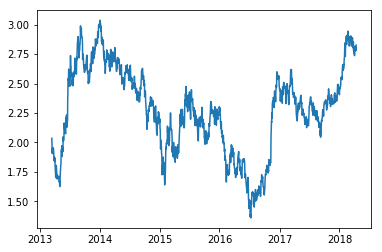

In [26]:
plt.plot(df_stock.open)

In [27]:
df_stock = df_stock.dropna()

In [28]:
diff_df = df_stock.diff().dropna()

In [29]:
diff_df = diff_df.reset_index(drop=True)

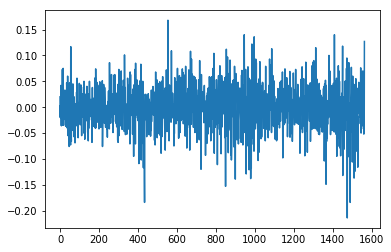

In [30]:
plt.plot(diff_df.open)

In [31]:
len(diff_df)

1564

In [32]:
diff_df.index = diff_df.date

AttributeError: 'DataFrame' object has no attribute 'date'

In [33]:
diff_df = diff_df[[u'open',          u'high',           u'low',
               u'close',        u'volume',  u'close_26_ema',          u'macd',
               u'macds',         u'macdh',        u'middle', u'middle_14_sma',
                 u'cci',    u'close_-1_s',    u'close_-1_d',          u'rs_6',
               u'rsi_6',  u'close_10_sma',  u'close_50_sma',           u'dma',
          u'high_delta',            u'um',     u'low_delta',            u'dm',
                 u'pdm',    u'pdm_14_ema',        u'pdm_14',            u'tr',
              u'atr_14',        u'pdi_14',           u'pdi',           u'mdm',
          u'mdm_14_ema',        u'mdm_14',        u'mdi_14',           u'mdi',
               u'dx_14',            u'dx',      u'dx_6_ema',           u'adx',
           u'adx_6_ema',          u'adxr',          u'trix',           u'atr']]

In [34]:
diff_df_matrix = diff_df.as_matrix().astype(np.float)

In [35]:
np.any(np.isfinite(diff_df_matrix))

True

In [36]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [37]:
print(diff_df_matrix[:,0].shape)
index = 0
for i in diff_df_matrix[:,0]:
    if np.isnan(i):
        print(index, i)
    index +=1

(1564,)


In [45]:
diff_df_matrix = clean_dataset(diff_df)

In [39]:
diff_df_matrix.shape

(1563, 43)

In [53]:
data_raw_x = diff_df_matrix
#data_raw_y = diff_df_matrix[:,[1,2,3,4,5]]# convert to numpy array

min_max_scaler_x = MinMaxScaler()
x_norm = min_max_scaler_x.fit_transform(np.reshape(diff_df_matrix['open'],(-1, 1)))

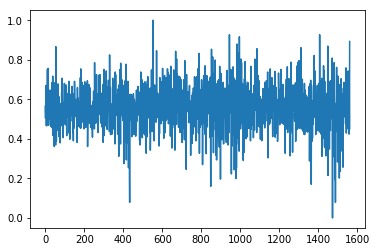

In [54]:
plt.plot(x_norm)

In [817]:
data_raw_x = diff_df_matrix
data_raw_y = diff_df_matrix[:,[1,2,3,4,5]]# convert to numpy array

min_max_scaler_x = StandardScaler()
x_norm = min_max_scaler_x.fit_transform(data_raw_x)
print x_norm.shape

x_norm = util.add_date_features(pd.datetime(2013,4,13), x_norm)

min_max_scaler_y = MinMaxScaler()
y_norm = min_max_scaler_y.fit_transform(data_raw_y)

index_range_x = 90 + 90

data = []
data_y = []


    # create all possible sequences of length seq_len
for index in range(len(x_norm) - index_range_x):
    data.append(x_norm[index: index + 90])

for index in range(90, len(y_norm) - 90):
    data_y_array = y_norm[index: index + 90]
    data_y.append(data_y_array)

data = np.array(data);
data_y = np.array(data_y);
valid_set_size = int(np.round(np.float(util.valid_set_size_percentage) / 100 * data.shape[0]));
test_set_size = int(np.round(np.float(util.test_set_size_percentage) / 100 * data.shape[0]));
train_set_size = data.shape[0] - (valid_set_size + test_set_size);

x_train = data[:train_set_size, :-1, :]
y_train = data_y[:train_set_size, :-1, :]

x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
y_valid = data_y[train_set_size:train_set_size + valid_set_size, :-1, :]

x_test = data[train_set_size + valid_set_size:, :-1, :]
y_test = data_y[train_set_size + valid_set_size:, :-1, :]

(1563, 43)


In [818]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(89,124)))
model.add(LSTM(256,input_shape=(89,124),activation='tanh',return_sequences=True))
model.add(Dropout(0.10))
model.add(LSTM(145, activation='tanh', return_sequences=True))
model.add(Dropout(0.10))
model.add(LSTM(95, activation='tanh', return_sequences=True))
model.add(Dropout(0.10))
#model.add(Flatten())
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',loss='mse')
history = model.fit(x_train, y_train, epochs=200,validation_data=(x_valid,y_valid),shuffle=False)

Train on 1107 samples, validate on 138 samples
Epoch 1/200
1107/1107 [==============================] - 34s 31ms/step - loss: 0.0140 - val_loss: 0.0086
Epoch 2/200
1107/1107 [==============================] - 30s 27ms/step - loss: 0.0119 - val_loss: 0.0082
Epoch 3/200
1107/1107 [==============================] - 30s 27ms/step - loss: 0.0109 - val_loss: 0.0081
Epoch 4/200
1107/1107 [==============================] - 29s 26ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 5/200
1107/1107 [==============================] - 29s 26ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 6/200
1107/1107 [==============================] - 29s 26ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 7/200
1107/1107 [==============================] - 29s 26ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 8/200
1107/1107 [==============================] - 32s 29ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 9/200
1107/1107 [==============================] - 26s 24ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10

KeyboardInterrupt: 

In [614]:
model.save('rf_lstm_model_200.h5')

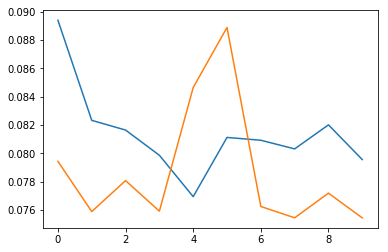

In [765]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [766]:
all_x = np.concatenate([x_train, x_test, x_valid])

In [767]:
all_y = np.concatenate([y_train, y_test, y_valid])

In [768]:
Xt = model.predict(all_x)

In [771]:
xt_0 = pd.DataFrame(Xt[0])
xt_0.index = xt_0.index+90
y_test_df = pd.DataFrame(all_y[0])
y_test_df.index = y_test_df.index+90
x_test_df = pd.DataFrame(all_x[0])

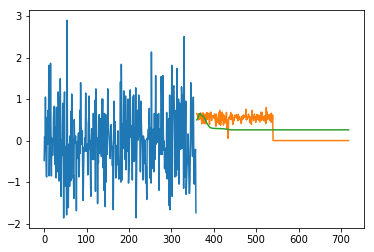

In [772]:
plt.plot(x_test_df[0])
plt.plot(y_test_df[0])
plt.plot(xt_0[0])

In [621]:
all_x.shape

(1383, 89, 124)

In [774]:
new_x = np.reshape(all_x[1], (89, 124))
for i in range(2, all_x.shape[0]/90+1):
    next_x = np.reshape(all_x[i*90], (89, 124))
    new_x = np.concatenate([new_x,next_x])

In [623]:
def inverse_x(x_matrix, min_max_scaler_x, begin_df):
    new_x = np.reshape(x_matrix[1], (89, 124))
    for i in range(2, x_matrix.shape[0]/90+1):
        next_x = np.reshape(x_matrix[i*90], (89, 124))
        new_x = np.concatenate([new_x,next_x])
    reverse_scale = min_max_scaler_x.inverse_transform(new_x[:,1:44])
    reverse_x_df = pd.DataFrame(reverse_scale)
    reverse_x_df.columns=begin_df.columns
    inverse_df_x = inverse_df(begin_df, reverse_x_df, reverse_x_df.columns)
    return inverse_df_x

In [775]:
reverse_scale = min_max_scaler_x.inverse_transform(new_x[:,1:44])

In [776]:
reverse_x_df = pd.DataFrame(reverse_scale)

In [777]:
reverse_x_df.columns=df_stock.columns

In [778]:
inverse_df_x = inverse_df(df_stock, reverse_x_df, reverse_x_df.columns)

In [628]:
def inverse_y(y_matrix, min_max_scaler_y, input_predict):
    new_y = np.reshape(y_matrix[1], (89, 4))
    for i in range(2, y_matrix.shape[0]/90+1):
        next_y = np.reshape(y_matrix[i*90], (89, 4))
        new_y = np.concatenate([new_y,next_y])
    reverse_scale_y = min_max_scaler_y.inverse_transform(new_y)
    reverse_y_df = pd.DataFrame(reverse_scale_y)
    reverse_y_df.columns=['open', 'high', 'low', 'close']
    inverse_df_y = inverse_df(input_predict[90:90], reverse_y_df, ['open', 'high', 'low', 'close'])
    return

In [779]:
Xt.shape

(1023, 359, 5)

In [780]:
new_y = np.reshape(Xt[1], (89, 5))
for i in range(2, all_y.shape[0]/90+1):
    next_y = np.reshape(Xt[i*90], (89, 5))
    new_y = np.concatenate([new_y,next_y])
reverse_scale_y = min_max_scaler_y.inverse_transform(new_y)
reverse_y_df = pd.DataFrame(reverse_scale_y)
reverse_y_df.columns=['open', 'high', 'low', 'close', 'volume']
inverse_df_y = inverse_df(df_stock[90:90], reverse_y_df, ['open', 'high', 'low', 'close', 'volume'])

In [781]:
len(inverse_df_y)

718

In [782]:
old_y = np.reshape(all_y[1], (89, 5))
for i in range(2, all_y.shape[0]/90+1):
    next_y = np.reshape(all_y[i*90], (89, 5))
    old_y = np.concatenate([new_y,next_y])
reverse_scale_y_old = min_max_scaler_y.inverse_transform(old_y)
reverse_y_df_old = pd.DataFrame(reverse_scale_y_old)
reverse_y_df_old.columns=['open', 'high', 'low', 'close', 'volume']
inverse_df_y_old = inverse_df(df_stock[90:90], reverse_y_df_old, ['open', 'high', 'low', 'close', 'volume'])

In [783]:
np.average(reverse_y_df_old.open)

-0.11753696785218309

In [784]:
np.average(reverse_y_df.open)

-0.11713833

In [785]:
len(inverse_df_y_old)

1077

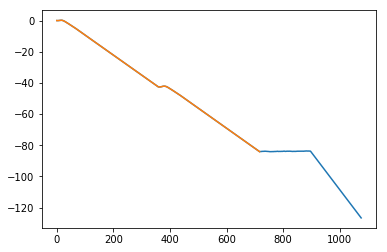

In [786]:
plt.plot(inverse_df_y_old.open)
plt.plot(inverse_df_y.open)

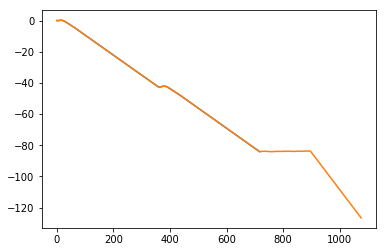

In [787]:
plt.plot(inverse_df_y.open)
plt.plot(inverse_df_y_old.open)

In [788]:
len(df_stock)

1565

In [789]:
last_predict = df_stock[(len(df_stock)-1)-359:len(df_stock)]

In [643]:
last_predict.index = last_predict.index.droplevel(0)

AttributeError: 'DatetimeIndex' object has no attribute 'droplevel'

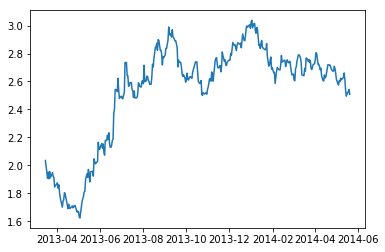

In [790]:
plt.plot(last_predict['open'])

In [791]:
last_predict_diff = last_predict.diff().dropna()

In [792]:
last_predict_matrix = last_predict_diff.as_matrix()

In [793]:
last_predict_norm = min_max_scaler_x.transform(last_predict_matrix)

In [795]:
x_norm = np.reshape(util.add_date_features(last_predict_diff.index[0], last_predict_norm), (1, 359, 124))

In [796]:
last_predict_y = np.reshape(model.predict(x_norm), (359,5))

In [797]:
reverse_scale_predict = min_max_scaler_y.inverse_transform(last_predict_y)
reverse_predict = pd.DataFrame(reverse_scale_predict)
reverse_predict.columns=['open', 'high', 'low', 'close','volume']
inverse_df_predict = inverse_df(last_predict[359:360], reverse_predict, ['open', 'high', 'low', 'close','volume'])

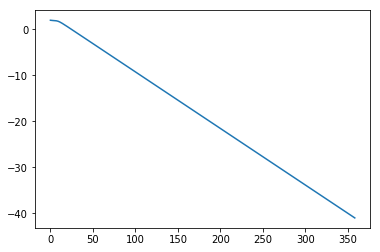

In [798]:
plt.plot(inverse_df_predict['open'])

In [654]:
inverse_df_predict.index = pd.date_range(start=pd.datetime(2018, 4, 13), end=pd.datetime(2018,7,10))

In [655]:
pd.datetime(2018,4,13) + datetime.timedelta(days=90)

datetime.datetime(2018, 7, 12, 0, 0)

In [568]:
df_stock.index = df_stock.index.droplevel(0)

AttributeError: 'DatetimeIndex' object has no attribute 'droplevel'

In [656]:
add_prediction = inverse_df_predict.append(df_stock[['open', 'high', 'low', 'close', 'volume']])

In [657]:
add_prediction = add_prediction.sort_index()

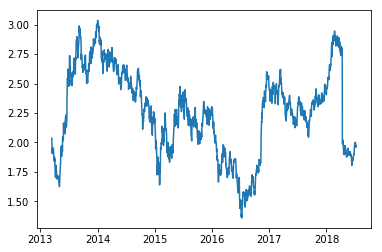

In [658]:
#last_predict = last_predict.reset_index(drop=True)
#df_stock = df_stock.reset_index(drop=True)
#inverse_df_predict.index = inverse_df_predict.index - len(df_stock)
#plt.plot(last_predict['open'])
plt.plot(add_prediction['open'])
#plt.plot(inverse_df_predict['open'])

In [585]:
add_prediction.to_csv('rf_prediction.csv')

In [699]:
new_predict = add_prediction[-95:-1]

In [700]:
add_prediction[-2:-1]

,open,high,low,close,volume
2018-10-05,1.710445,1.627479,1.222621,2.208516,-0.553729


In [701]:
new_predict.columns = [['Open', 'High', 'Low', 'Close', 'Volume']]

In [702]:
new_predict = find_stock_features(new_predict)

In [703]:
new_predict.head()

,open,high,low,close,volume,close_26_ema,macd,macds,macdh,middle,...,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,atr
2018-07-05,1.983726,2.030463,1.824853,2.022792,-0.158224,2.022792,0.000000,0.000000,0.000000,1.959369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06,1.989968,2.024835,1.806751,2.010755,-0.154641,2.016542,-0.000270,-0.000150,-0.000240,1.947447,...,4.446585,4.446585,100.0,100.0,100.0,100.0,100.0,100.0,-0.094575,0.218083
2018-07-07,1.965619,2.019991,1.806739,2.022861,-0.152616,2.018812,0.000031,-0.000076,0.000214,1.949863,...,2.782161,2.782161,100.0,100.0,100.0,100.0,100.0,100.0,-0.034405,0.215578
2018-07-08,1.969547,2.013712,1.778029,2.001197,-0.153390,2.013888,-0.000615,-0.000258,-0.000713,1.930979,...,5.726725,5.726725,100.0,100.0,100.0,100.0,100.0,100.0,-0.045699,0.226060
2018-07-09,1.958880,1.996915,1.796953,2.035165,-0.153252,2.018822,0.000399,-0.000063,0.000924,1.943011,...,4.349504,4.349504,100.0,100.0,100.0,100.0,100.0,100.0,-0.019758,0.219986


In [704]:
new_predict = new_predict.dropna()
new_predict = new_predict.diff().dropna()
new_predict = new_predict.reset_index(drop=True)
new_predict = new_predict[[u'open',          u'high',           u'low',
               u'close',        u'volume',  u'close_26_ema',          u'macd',
               u'macds',         u'macdh',        u'middle', u'middle_14_sma',
                 u'cci',    u'close_-1_s',    u'close_-1_d',          u'rs_6',
               u'rsi_6',  u'close_10_sma',  u'close_50_sma',           u'dma',
          u'high_delta',            u'um',     u'low_delta',            u'dm',
                 u'pdm',    u'pdm_14_ema',        u'pdm_14',            u'tr',
              u'atr_14',        u'pdi_14',           u'pdi',           u'mdm',
          u'mdm_14_ema',        u'mdm_14',        u'mdi_14',           u'mdi',
               u'dx_14',            u'dx',      u'dx_6_ema',           u'adx',
           u'adx_6_ema',          u'adxr',          u'trix',           u'atr']]
new_predict_matrix = clean_dataset(new_predict).as_matrix()

In [705]:
new_predict_matrix = new_predict_matrix[2:91,:]

In [706]:
new_predict_norm = min_max_scaler_x.transform(new_predict_matrix)

In [707]:
new_predict_norm.shape

(89, 43)

In [708]:
new_predict_norm = np.reshape(util.add_date_features(pd.datetime(2018,4,12), new_predict_norm), (1,89,124))

In [709]:
new_predict_y = np.reshape(model.predict(new_predict_norm), (89,5))

In [710]:
new_predict_y = min_max_scaler_y.inverse_transform(new_predict_y)
reverse_predict_y = pd.DataFrame(new_predict_y)
reverse_predict_y.columns=['open', 'high', 'low', 'close','volume']
inverse_df_predict_y = inverse_df(add_prediction[-2:-1], reverse_predict_y, ['open', 'high', 'low', 'close','volume'])

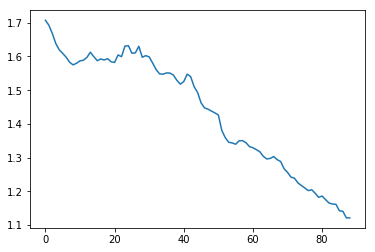

In [711]:
plt.plot(inverse_df_predict_y.open)

In [713]:
inverse_df_predict_y.index = pd.date_range(start=pd.datetime(2018, 10, 6), end=pd.datetime(2019,1,2))

In [714]:
add_prediction = add_prediction.append(inverse_df_predict_y).sort_index()

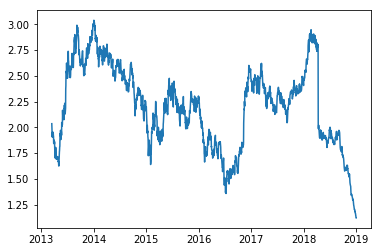

In [715]:
plt.plot(add_prediction.open)